# Finding a detection strategy
It is necesary to obtain the bounding box of the faces present for every frame on all videos. The GPU-backed face detector allows to efficiently process many frames in parallel. Despite this, running the face detector for all frames adds up to a considerable time. Addtionally, the face detector is agnostic to previous results leading to undesirable gaps and jittering. A gap is a short secuence of frames where the face remains undetected before suddenly returning, while jittering presents itself when succesive high-frequency detections result in bounding box coordinates that sharply oscillate.

Lowering the number of frames run trough the face detector the total time for the operation can be atenuated. The factor for wich the detection is sped-up is given by the ratio between the video length and the time spent processing it. The video dimesions are also a factor to consider, as a bigger frame will implies more time transfering data between memories. To find the speedup factor a random sample of 150 videos was selected and the face detector run with a frame rate of 30, 15, 6, and 3 FPS. As per default configuration, all videos were resized by a factor of 8. A second run capped the resolution to a maximum of *NUM x NUM*, keeping the aspect ratio.

> 30FPS was used as a base reference for it being the maximum frame rate posible with the acquired videos. 1000 Random samples of 5 seconds were extracted from the 3846 tracks.

> The high-frequency error can be filtered by running a smoothing operation. This takes the form of a moving window averaging past detections. A stable detection sequence can be improved by adjusting the contribution of the elements by their relative distance to the sampled item. Several weighting strategies were tried and the one with the lowest MSE was chosen. The smoothed 30FPS sequence is the closest to an ideal result and it will be used as a reference for further experiments.

> This introduces periodical and regular gaps on the sequence of bounding boxes. Applying an extrapolation strategy can fill any existing gaps. Additionally lowering the frequency of detections can mitigate jittering by smoothing the transition between detected points. Several interpolation estrategies can be tried. Implementation of spline interpolators of zeroth, first, second and third order are already available on the *Python* library *SciPy*.

> Weights with uniform contribution, linearly decreasing and gaussian distributed were compared.

> A sample of 150 randomly selected files were used to find a usefull strategy.

> Sampling rates of 15, 6, and 3 FPS were compared against a gaussian-smoothed .

> ## Compensating for the jittering
> 30FPS is too high-frequency, it introduces jittering.

> Jittering is an undesired problem on the high-frequency 30FPS tracked boxes used as reference samples. Applying a moving window averaging the previous elements acts as a low-pass filter reducing the jitter. Three weighting strategies were used: uniform, lineal and gaussian.

> + Uniform estrategy averages the last n elements with equal weights.
> + Linear strategy weights the elements by the time-distance to the current sample, normalized by the longest.
> + Gaussian strategy weights by the gaussian value on the time-axis, centered on the current sample with a standard deviation of the detection period.

> + Does lowering the frame rate make an improovement on detection time?
    + By how much?
    + Thresholding the frame size to a maximum value may help too, what dimensions to use as threshold?
> + Averaging past detections decrease the jittering?
    + Which performs the best?
> + Which interpolation strategy is closer to the true detection?
    + Which is closer to the softened detection?

In [1]:
VIDEO_LENGTH_FILE = r'../data/video_length.csv'
TRACK_LENGTH_FILE = r'../data/track_length.csv'
TRACK_POINTS_FILE = r'../data/video_points.pkl'
TRACK_FOLDERS = {
    30: r'../data/test_tracks@30FPS',
    15: r'../data/test_tracks@15FPS',
    6: r'../data/test_tracks@6FPS',
    3: r'../data/test_tracks@3FPS',
}
REFERENCE_FRAME_RATE = 30
SAMPLE_LENGTH = 5.0
SAMPLE_NUM = 5000

In [2]:
%matplotlib inline
import json
import pickle
from datetime import timedelta
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.interpolate import interp1d

In [3]:
def load_length_data(track_folders):
    video_data = []
    track_data = []
    
    for fps, path in track_folders.items():
        for track_file in Path(path).glob('**/*.tracks.json'):
            with track_file.open('r', encoding='utf8') as fp:
                track_file = json.load(fp)
            
            # Video lengths
            video_data.append([track_file['video_duration'],
                               track_file['detection_duration'],
                               track_file['width'],
                               track_file['height'],
                               fps])

            # Track lengths
            for track in track_file['tracks'].values():
                track_data.append([track['time'][-1] - track['time'][0],
                                   track_file['width'],
                                   track_file['height'],
                                   fps])
    return video_data, track_data

In [4]:
def load_point_data(track_folder):
    data_time = []
    data_bbox = []
    data_tlen = []

    for track_file in Path(track_folder).glob('**/*.tracks.json'):
        with track_file.open('r', encoding='utf8') as fp:
            track_file = json.load(fp)

        # Ignore videos without tracks
        if len(track_file['tracks']) == 0:
            continue

        track_time, track_bbox = zip(*[(t['time'], t['bbox']) for t in track_file['tracks'].values()])

        track_time = list(track_time)
        track_bbox = list(track_bbox)
        track_tlen = []

        for i, (t, b) in enumerate(zip(track_time, track_bbox)):        
            # All tracks start from 0
            t = np.float32(t) - t[0]
            track_time[i] = t.tolist()

            # Length of a track in seconds
            track_tlen.append(t[-1])

            # Box positions from screen center
            b = np.float32(b).reshape(-1, 2, 2)
            b[:, :, 0] -= 0.5 * track_file['width']
            b[:, :, 1] -= 0.5 * track_file['height']
            track_bbox[i] = b.tolist()

        data_time.extend(track_time)
        data_bbox.extend(track_bbox)
        data_tlen.extend(track_tlen)
    return data_time, data_bbox, data_tlen

In [5]:
video_data_src = Path(VIDEO_LENGTH_FILE)
track_data_src = Path(TRACK_LENGTH_FILE)
point_data_src = Path(TRACK_POINTS_FILE)

video_data_columns = [('video_length', float),
                      ('time_detecting', float),
                      ('width', int),
                      ('height', int),
                      ('fps', int)]
track_data_columns = [('track_length', float),
                      ('width', int),
                      ('height', int),
                      ('fps', int)]

In [6]:
# Load video data
if video_data_src.exists() and track_data_src.exists:
    video_df = pd.read_csv(video_data_src, index_col=0, dtype=dict(video_data_columns))
    track_df = pd.read_csv(track_data_src, index_col=0, dtype=dict(track_data_columns))
else:
    video_data, track_data = load_length_data(TRACK_FOLDERS)
    
    video_df = pd.DataFrame.from_records(video_data, columns=[n for n, t in video_data_columns])
    track_df = pd.DataFrame.from_records(track_data, columns=[n for n, t in track_data_columns])
    
    video_df.to_csv(video_data_src)
    track_df.to_csv(track_data_src)

In [7]:
# Load track data
if point_data_src.exists():
    with point_data_src.open('rb') as fp:
        data_time, data_bbox, data_tlen = pickle.load(fp)
else:
    data_time, data_bbox, data_tlen = load_point_data(TRACK_FOLDERS[REFERENCE_FRAME_RATE])
    
    with point_data_src.open('wb') as fp:
        pickle.dump((data_time, data_bbox, data_tlen), fp, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
print('Number of tracks:', len(data_time))

Number of tracks: 3846


In [9]:
# Sampling tracks
np.random.seed(0)

# Pick random track and a random position to start a slice
track_samples = (np.random.random(SAMPLE_NUM) * len(data_time)).astype(int)
track_start = np.random.random(SAMPLE_NUM) * (np.float32(data_tlen)[track_samples] - SAMPLE_LENGTH)

test_time = []
test_bbox = []

for ti, ts in zip(track_samples, track_start):
    t_time = []
    t_bbox = []
    # Add the frames that lie between the picked slice bounds
    for i in range(len(data_time[ti])):
        if ts <= data_time[ti][i] < ts + SAMPLE_LENGTH:
            t_time.append(data_time[ti][i])
            t_bbox.append(data_bbox[ti][i])
    # Make slices start from 0
    test_time.append(np.float32(t_time) - t_time[0])
    test_bbox.append(np.float32(t_bbox))

# Results

In [10]:
video_df['area'] = video_df['width'] * video_df['height']
video_df['speedup'] = video_df['video_length'] / video_df['time_detecting']

df = video_df.groupby(['area', 'fps']).agg([np.mean, np.std]).reset_index(level='area')

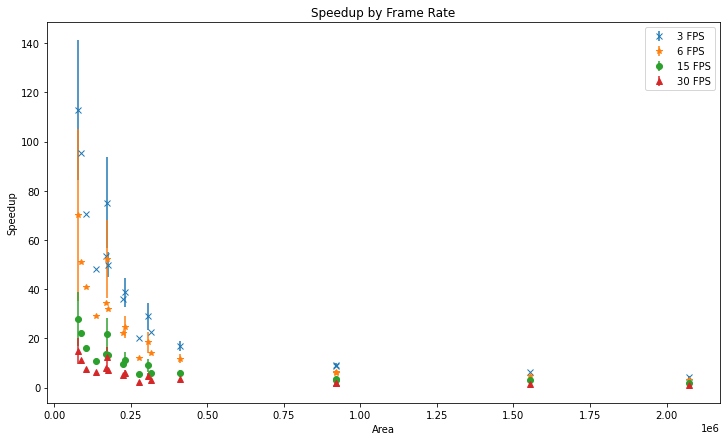

In [11]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
markers='x*o^'

for marker, (key, group) in zip(markers, df.groupby('fps')):
    yerr = group[('speedup', 'std')].fillna(0)
    ax.errorbar(group['area'], group[('speedup', 'mean')], yerr=yerr, fmt=marker, label=f'{key} FPS')

fig.tight_layout()
plt.title('Speedup by Frame Rate')
plt.xlabel('Area')
plt.ylabel('Speedup')
plt.legend()
plt.show()

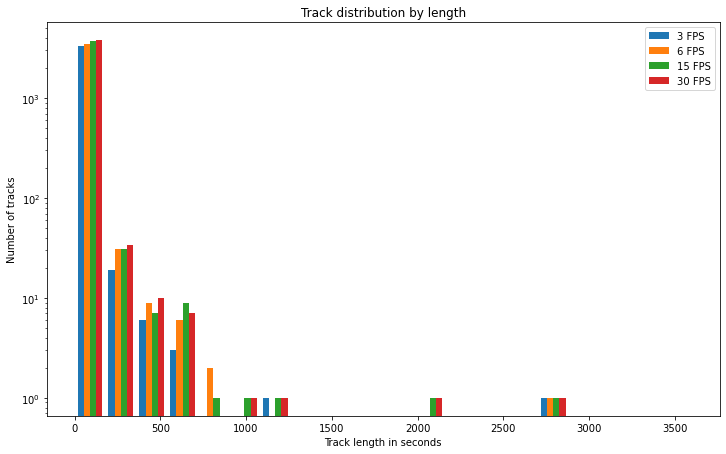

In [12]:
# Track distribution by duration color by framerate
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()

labels, track_lengths = zip(*[(f'{key} FPS', group['track_length']) for key, group in track_df.groupby('fps')])
ax.hist(track_lengths, bins=20, label=labels, range=(0, 3600))
ax.set_yscale('log')

fig.tight_layout()
plt.title('Track distribution by length')
plt.xlabel('Track length in seconds')
plt.ylabel('Number of tracks')
plt.legend()
plt.show()

In [13]:
def gaussian(x, mu, sigma):
    return (1.0 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-((x - mu)**2) / (2 * sigma**2))

def soften(x, y, win_size, fn):
    soft_y = []
    for c in range(len(x)):
        istart = max(c - win_size, 0)
        iend = c + 1
        # iend = min(c + win_size, len(x)-1)
        weights = fn(x[istart:iend])
        weights = weights / np.sum(weights)
        soft_y.append(np.average(y[istart:iend], weights=weights, axis=0))
    return np.float32(soft_y)

def mse(x0, x1, axis=None):
    return np.mean((x0 - x1)**2)

def get_center_area(bbox):
    cter = np.sqrt(np.sum((0.5 * np.sum(bbox, axis=1))**2, axis=-1))
    area = (bbox[:, 1, 0] - bbox[:, 0, 0]) * (bbox[:, 1, 1] - bbox[:, 0, 1])
    cter = cter - np.mean(cter)
    area = area - np.mean(area)
    return cter, area

def get_error(ldiff):
    udiff = -ldiff
    ldiff[ldiff < 0] = 0
    udiff[udiff < 0] = 0
    return (ldiff, udiff)

def select_times(in_times, in_period, out_period):
    out_times = np.round(in_times / in_period).astype(int)
    k = int(np.round(out_period / in_period))
    out_times = np.mod(out_times, k)
    return np.argwhere(out_times == 0)

In [14]:
test_cases = { 
    'Uniform': lambda x: np.ones_like(x),
    'Linear': lambda x: 1.0 / (np.abs(x - x[-1]) + 1.0),
    'Gaussian': lambda x: gaussian(x, x[-1], 1.0 / REFERENCE_FRAME_RATE),
}

softened_bbox = {k: [] for k in test_cases}
cat_test_bbox = np.concatenate(test_bbox)
for label, op in test_cases.items():
    for true_time, true_bbox in zip(test_time, test_bbox):    
        soft_bbox = soften(true_time, true_bbox, 5, op)
        softened_bbox[label].append(soft_bbox)
    print(label, 'MSE:', mse(cat_test_bbox, np.concatenate(softened_bbox[label])))

Uniform MSE: 55.15478
Linear MSE: 51.943024
Gaussian MSE: 8.683383


In [15]:
err = []
for true_time, true_bbox in zip(test_time, test_bbox):    
    soft_bbox = soften(true_time, true_bbox, 5, test_cases['Gaussian'])
    err.append(mse(true_bbox, soft_bbox))

example_idx = {
    'Min Error': np.argmin(err),
    'Median Error': np.argsort(err)[len(err)//2],
    'Max Error': np.argmax(err),
}

Min Error - Uniform 0.00061454327
Min Error - Linear 0.00057862117
Min Error - Gaussian 7.5552445e-05
Median Error - Uniform 19.526358
Median Error - Linear 18.703672
Median Error - Gaussian 5.4065638
Max Error - Uniform 2227.1348
Max Error - Linear 2081.5735
Max Error - Gaussian 268.77246


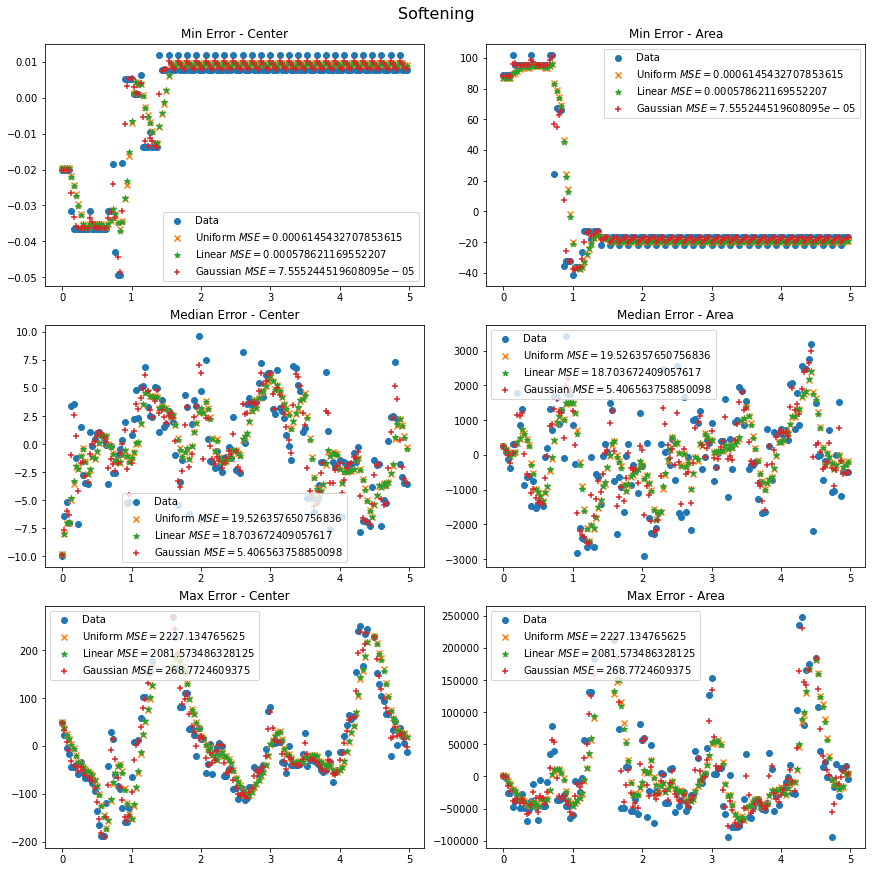

In [16]:
fig, axs = plt.subplots(nrows=len(example_idx),
                        ncols=2,
                        figsize=(4*len(example_idx), 12),
                        constrained_layout=True,
                        squeeze=False)

for i, (name, eidx) in enumerate(example_idx.items()):
    cter_ax = axs[i, 0]
    area_ax = axs[i, 1]
    
    true_time = test_time[eidx]
    true_bbox = test_bbox[eidx]

    true_cter, true_area = get_center_area(true_bbox)
    cter_ax.scatter(true_time, true_cter, marker='o', label='Data')
    area_ax.scatter(true_time, true_area, marker='o', label='Data')

    # Plot softened data with the displacement from True with an error bar
    for (label, op), m in zip(test_cases.items(), 'x*+'):
        soft_bbox = soften(true_time, true_bbox, 5, op)
        soft_cter, soft_area = get_center_area(soft_bbox)

        mse_err = mse(test_bbox[eidx], softened_bbox[label][eidx])
        print(name + ' - ' + label, mse_err)

        cter_ax.scatter(true_time, soft_cter, marker=m, label=label + f' $MSE={mse_err}$')
        area_ax.scatter(true_time, soft_area, marker=m, label=label + f' $MSE={mse_err}$')

    cter_ax.set_title(name + ' - Center')
    cter_ax.legend()
    area_ax.set_title(name + ' - Area')
    area_ax.legend()

fig.suptitle('Softening', fontsize=16)
plt.show()

In [17]:
interpolation_kinds = ['zero', 'slinear', 'quadratic', 'cubic']
frame_rates = [15, 6, 3]
soft_type = ['', '+Gauss']

op = lambda x: gaussian(x, x[-1], 1.0 / REFERENCE_FRAME_RATE)
reference_soft_bbox = [soften(time, bbox, 5, op) for time, bbox in zip(test_time, test_bbox)]
cat_reference_soft_bbox = np.concatenate(reference_soft_bbox)

mse_results = {}
mse_soft_results = {}
transformed_bbox = {}
table = []
for fr in frame_rates:
    for kind in interpolation_kinds:
        for is_soft in soft_type:
            label = f'{kind}{is_soft}@{fr}FPS'
            transformed_bbox[label] = transformed_bbox.get(label, [])
            
            for true_time, true_bbox in zip(test_time, test_bbox):
                idx = select_times(true_time, 1.0 / REFERENCE_FRAME_RATE, 1.0 / fr)
                time = true_time[idx].flatten()
                bbox = true_bbox[idx].reshape(-1, 2, 2)
                
                if len(is_soft) != 0:
                    bbox = soften(time, bbox, 5, op)
                try:
                    bbox_inter = interp1d(time, bbox, kind=kind, bounds_error=False, fill_value='extrapolate', axis=0)
                    y = bbox_inter(true_time)
                except ValueError as e:
                    y = np.zeros_like(true_bbox)
                transformed_bbox[label].append(y)
            
            mse_true = mse(cat_test_bbox, np.concatenate(transformed_bbox[label]))
            mse_soft = mse(cat_reference_soft_bbox, np.concatenate(transformed_bbox[label]))
            
            mse_results[label] = mse_true
            mse_soft_results[label] = mse_soft
            table.append([kind, len(is_soft) != 0, fr, mse_true, mse_soft])
            # print(label, 'MSE:', mse_true, 'Soft MSE:', mse_soft)

df = pd.DataFrame(table, columns=['interpolation_type', 'gaussian_softening', 'frame_rate', 'MSE', 'MSE_soft'])

In [18]:
display(df)

,interpolation_type,gaussian_softening,frame_rate,MSE,MSE_soft
0,zero,False,15,26.008737,14.026126
1,zero,True,15,25.869938,11.737385
2,slinear,False,15,16.547464,12.125493
3,slinear,True,15,16.780462,9.257911
4,quadratic,False,15,22.902320,18.147633
5,quadratic,True,15,21.170402,13.228348
6,cubic,False,15,173.755611,168.949809
7,cubic,True,15,123.958915,115.945590
8,zero,False,6,77.170027,53.690201
9,zero,True,6,77.170106,53.690222


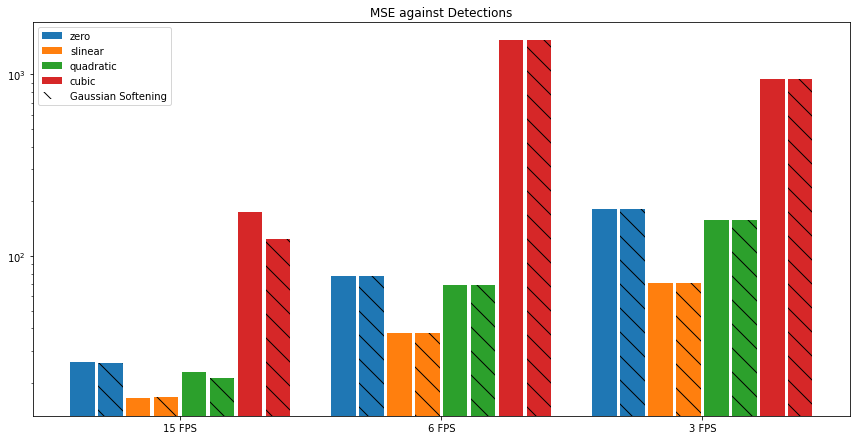

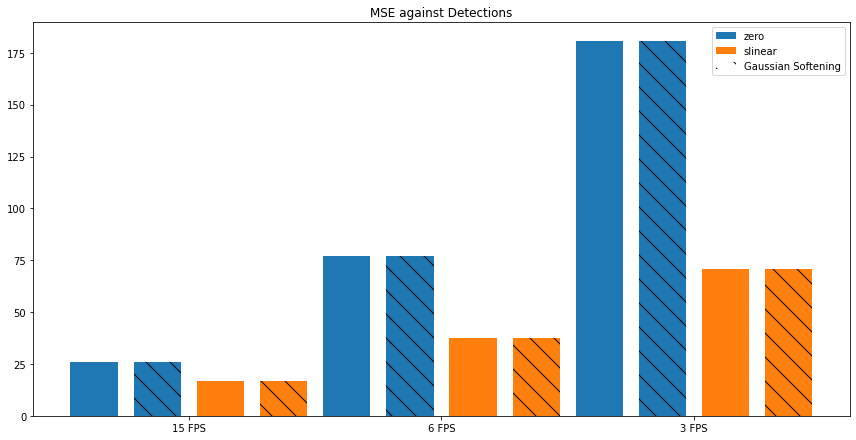

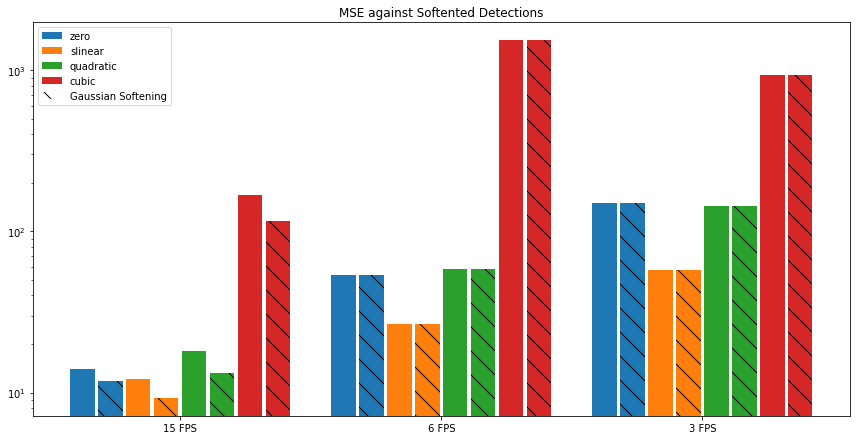

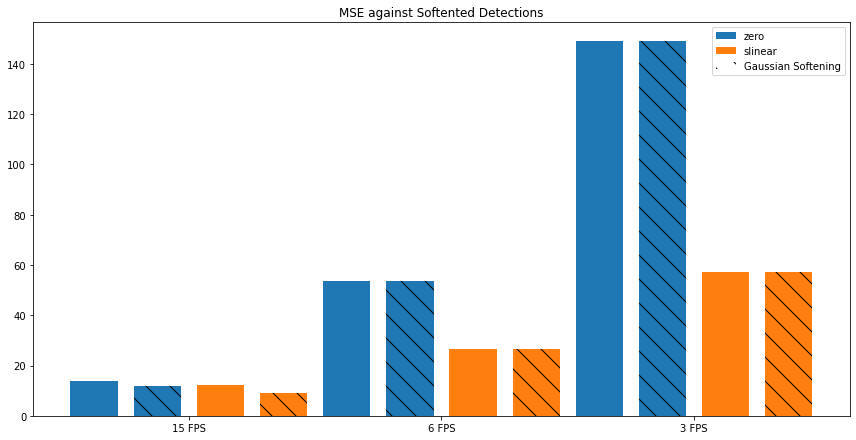

In [19]:
width = 0.75
hatch_pattern = '\\'

def plot_fig(results, interpolation_kinds, use_log, title):
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes()

    positions = np.stack([np.linspace(i - width / 2, i + width/2, len(soft_type) * len(interpolation_kinds))
                          for i in np.arange(len(frame_rates))])
    positions = positions.reshape(len(frame_rates), len(interpolation_kinds), len(soft_type))

    for i, kind in enumerate(interpolation_kinds):
        values = []
        for fr in frame_rates:
            values.extend([results[f'{kind}{is_soft}@{fr}FPS'] for is_soft in soft_type])
        b = ax.bar(positions[:, i].flatten(), values, width / (len(soft_type) * len(interpolation_kinds)), label=kind)
        for k, bb in enumerate(b):
            if k % 2 == 1:
                bb.set_hatch(hatch_pattern)
    if use_log:
        ax.set_yscale('log')
    fig.tight_layout()
    plt.xticks(np.arange(len(frame_rates)), [f'{fr} FPS' for fr in frame_rates])
    handles, labels = ax.get_legend_handles_labels()
    handles.append(Patch(facecolor='w', hatch=hatch_pattern, label='Gaussian Softening'))
    plt.legend(handles=handles)
    plt.title(title)
    plt.show()

plot_fig(mse_results, ['zero', 'slinear', 'quadratic', 'cubic'], True, 'MSE against Detections')
plot_fig(mse_results, ['zero', 'slinear'], False, 'MSE against Detections')
plot_fig(mse_soft_results, ['zero', 'slinear', 'quadratic', 'cubic'], True, 'MSE against Softented Detections')
plot_fig(mse_soft_results, ['zero', 'slinear'], False, 'MSE against Softented Detections')

# Apendix: Gauss Smoothing example
On the previous figure, the vertical lines are equally distance by the time between frames, or period $P$. For the third previous element, its contribution is close to zero.

Thus the weight of element $j$ with respect to element $i$ is:
$
W(t_j, t_i)=
\begin{cases}
    \frac{1}{P \sqrt{2 \pi}} e^{-\frac{1}{2}(\frac{t_j-t_i}{P})^2} & \forall j <= i\\
    0 & \text{otherwise}.
\end{cases}
$

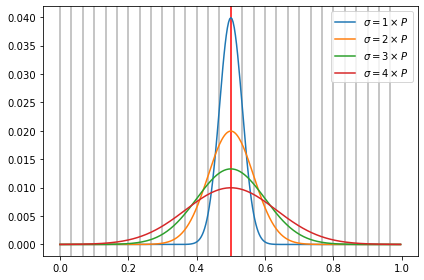

In [20]:
fig = plt.figure()
ax = plt.axes()

# Plot vertical lines
for x in np.arange(0, 1, (1.0 / 30.0)):
    if x == 0.5:
        color = 'red'
    else:
        color = '#0f0f0f50'
    plt.axvline(x=x, color=color)

# Plot gaussian distribution
x = np.arange(0, 1, 1.0 / 300.0)
for i in range(1, 5):
    y = gaussian(x, 0.5, i / 30.0)
    y = y / np.sum(y)
    ax.plot(x, y, label=f'$\sigma={i} \\times P$')

fig.tight_layout()
plt.legend()
plt.show()